### 2. Выбор модели для прогнозирования ВВП ЕС

### Проверка

- [RMSFE](https://otexts.com/fpp2/accuracy.html) 
- [Methods used in M3](https://www.sciencedirect.com/science/article/pii/S0169207006000239)
- [Regression and time series model selection in small samples](https://www.stat.berkeley.edu/~binyu/summer08/Hurvich.AICc.pdf): KL information


10% наблюдений

- rus: прогноз на 1/2 
- eu/us: прогноз на 4/8


- eu - каждое 4, зависимость точности вычислений и метода для рядов разной длины?

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Aggregated TS

In [2]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )

In [3]:
gdp_agg <- df_eu_sums <-  rowSums(df_eu)

In [4]:
gdp_agg %>% head()

2000-01-01 2000-04-01 2000-07-01 2000-10-01 2001-01-01 2001-04-01 
   2097016    2149714    2163305    2249545    2197372    2259781

In [5]:
gdp_agg  <- ts(gdp_agg, frequency = 4, start = 2000) 
gdp_agg

        Qtr1    Qtr2    Qtr3    Qtr4
2000 2097016 2149714 2163305 2249545
2001 2197372 2259781 2251095 2331590
2002 2292365 2334466 2334677 2411279
2003 2333137 2351889 2373162 2453219
2004 2419886 2491435 2490484 2564171
2005 2515137 2593341 2594523 2693043
2006 2655689 2724874 2745583 2852082
2007 2834787 2892483 2914308 2996058
2008 2923510 2963777 2946623 2919566
2009 2721873 2766663 2784353 2842605
2010 2784779 2873264 2893451 2968661
2011 2921483 2953958 2945649 3011265
2012 2958070 3010722 3033490 3075700
2013 2977965 3035742 3044227 3122904
2014 3072484 3133907 3160757 3236918
2015 3227776 3311839 3325372 3405251
2016 3304666 3362395 3318470 3395389
2017 3357919 3432684 3434182 3530894
2018 3471013 3542181 3541582        

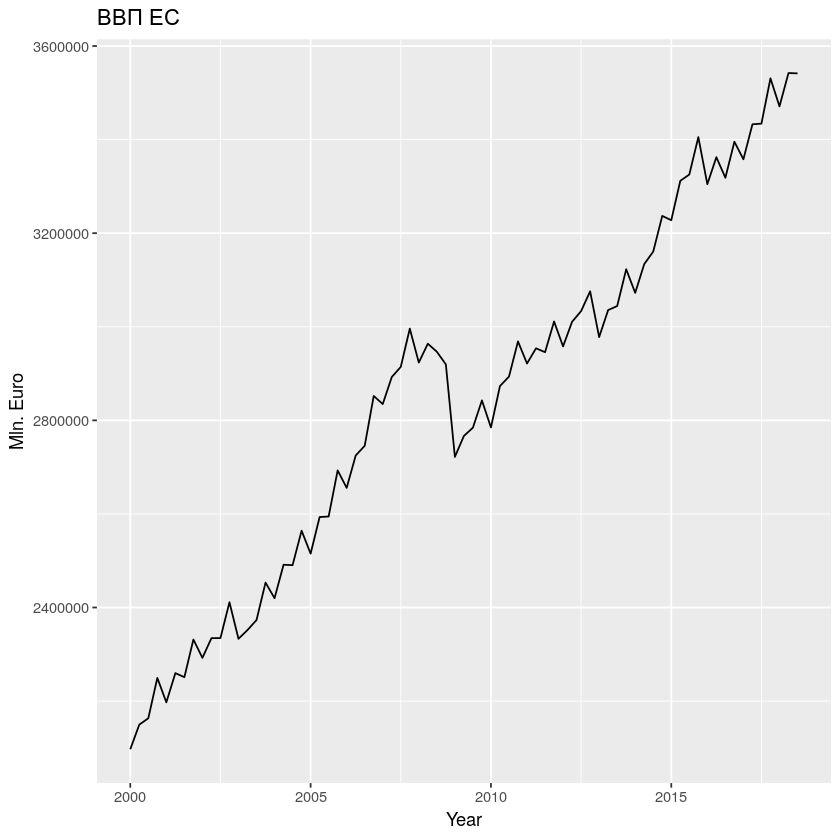

In [6]:
autoplot(gdp_agg) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("ВВП ЕС") 

In [7]:
train <- window(gdp_agg, end=c(2016,4))
test <- window(gdp_agg, start=c(2017,1))

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

#### Модель 1: Theta

``library(foreast)``

Equivalent to simple exponential smoothing with drift 

$\sim$ ETS(AAdN)

In [8]:
ets(train)

ETS(M,Ad,A) 

Call:
 ets(y = train) 

  Smoothing parameters:
    alpha = 0.972 
    beta  = 0.6358 
    gamma = 0.0042 
    phi   = 0.8 

  Initial states:
    l = 2108703.3746 
    b = 29348.6343 
    s = 43366.96 -8526.152 2324.243 -37165.05

  sigma:  0.0101

     AIC     AICc      BIC 
1688.558 1692.417 1710.753 

In [9]:
auto.arima(train)

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

In [10]:
auto.arima(train, ic='bic')

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

In [11]:
Arima(train, order=c(2,1,2), seasonal=c(2,1,2))

Series: train 
ARIMA(2,1,2)(2,1,2)[4] 

Coefficients:
          ar1      ar2     ma1     ma2     sar1     sar2     sma1    sma2
      -0.7498  -0.4656  1.3089  1.0000  -0.0792  -0.2608  -1.0277  0.0278
s.e.   0.1354   0.1253  0.0795  0.0902   0.4602   0.1355   0.5142  0.4875

sigma^2 estimated as 586803189:  log likelihood=-730.07
AIC=1478.14   AICc=1481.53   BIC=1497.42

In [12]:
gdp_rwf <- rwf(train,h=7)
gdp_rwfwd <- rwf(train,h=7, drift=TRUE)
gdp_snaive  <- snaive(train,h=7)
gdp_theta  <- thetaf(train, h=7)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=7)
gdp_auto_arima  <- forecast(auto.arima(train), h=7)
gdp_ets <- forecast(ets(train), h=7)

In [13]:
cat("RW")
accuracy(gdp_rwf, test)[, c(2,5,7,8)]
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("ETS")
accuracy(gdp_ets, test)[, c(2,5,7,8)]

RW

,RMSE,MAPE,ACF1,Theil's U
Training set,61957.82,1.882082,-0.4830031,NA
Test set,100924.98,2.517203,0.2892763,1.698108


RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,58849.27,1.7150060,-0.4830031,NA
Test set,34776.71,0.8161775,-0.3038002,0.4691468


SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,108505.4,3.463232,0.8651959,NA
Test set,146043.7,3.858363,0.5407384,2.451424


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


ETS

,RMSE,MAPE,ACF1,Theil's U
Training set,26248.54,0.7079164,0.02269934,NA
Test set,115786.51,3.0346545,0.58515778,1.95051


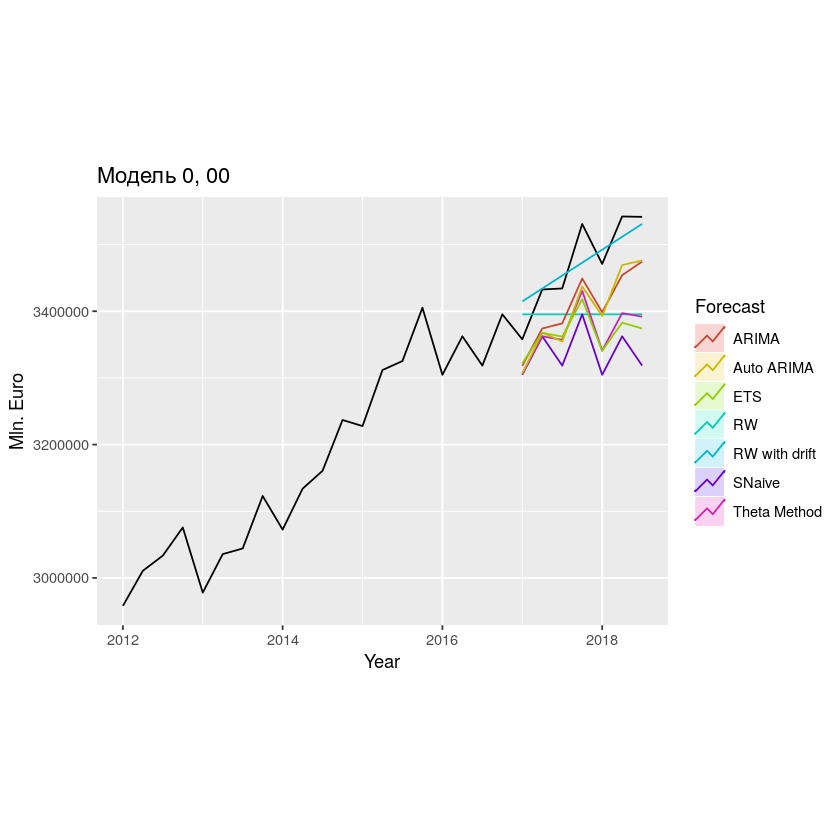

In [14]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwf, series="RW", PI=FALSE) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_snaive, series="SNaive", PI=FALSE) +
    autolayer(gdp_theta, series="Theta Method", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_ets, series="ETS", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

## Disaggregated TS

In [15]:
library(data.table)


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [16]:
df_eu = as.data.table(df_eu)

In [17]:
df_gdp_check  <- df_eu_sums

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

In [18]:
library(hts)  

In [19]:
data  <-  df_eu

In [20]:
head(data)

BEA,BEB,BEF,BEG,BEJ,BEK,BEL,BEM,BEO,BER,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
698.5,12887.5,2825.0,10591.5,2161.0,3509,5215.0,5877.5,11166.5,1211.0,⋯,3399.10,76488.40,22862.20,73151.90,23719.95,20741.50,57761.00,37932.55,62936.55,13489.10
749.5,13162.0,3037.5,10809.5,2160.5,3558,5335.0,6166.0,11481.0,1260.0,⋯,3548.80,75447.70,23319.40,73312.00,24628.50,20607.85,57974.95,39850.10,64350.75,13577.45
786.5,12941.0,2840.5,10664.5,2141.0,3569,5452.5,6301.0,11073.5,1257.5,⋯,3485.20,75416.75,23405.15,74807.70,25083.70,20351.05,58053.75,41213.95,65464.95,13748.05
781.5,13301.0,3108.5,11425.5,2330.5,3535,5528.0,6625.5,11661.5,1311.5,⋯,3469.00,79694.75,24750.20,76852.75,25989.25,19280.20,59448.60,42271.75,67689.75,13551.25
771.5,13219.5,2861.0,11164.5,2342.5,3452,5541.0,6534.5,11485.5,1246.5,⋯,3306.20,73919.55,22958.40,73992.25,24918.60,20554.10,57599.55,40398.35,65059.30,13200.30
745.5,13211.0,3149.0,11561.5,2416.5,3414,5604.5,6665.5,12023.5,1297.0,⋯,3565.45,73572.15,23664.10,78670.00,25203.90,20562.55,59190.70,42485.00,68913.70,14585.65


In [21]:
# rownames(data) = as.Date(data$X0)
# data$X0 <- NULL

In [22]:
dim(data)

[1]  75 280

In [23]:
y = hts(data, characters = c(2,1))
s = smatrix(y)

In [24]:
head(s)

1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [25]:
gts_train  <- window(y, start=1, end=68)
gts_test  <- window(y, start=69, end=75)

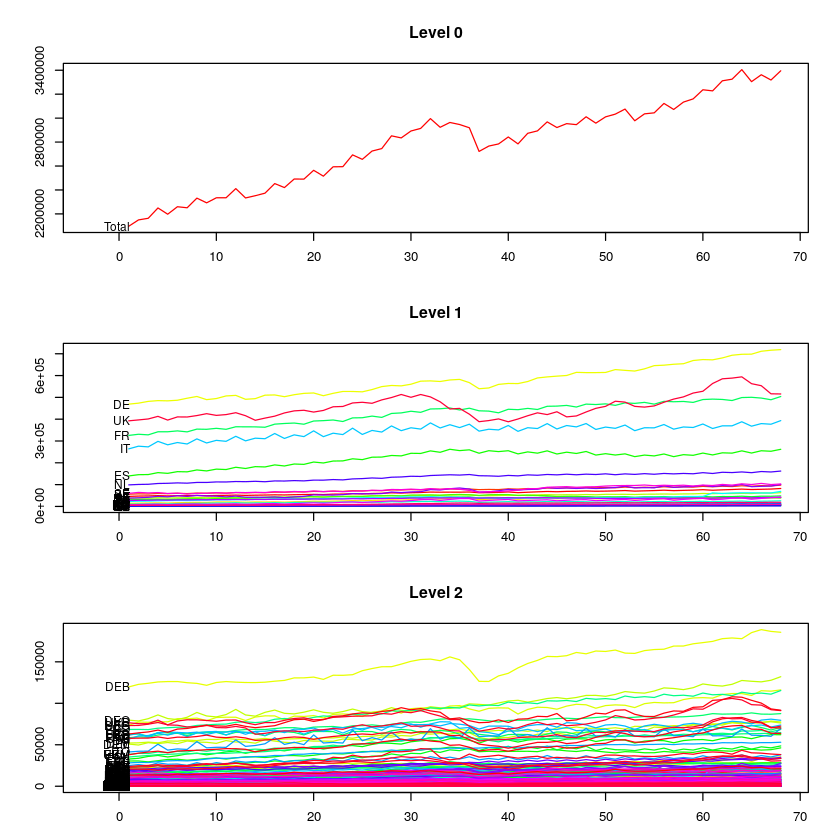

In [26]:
plot(gts_train, levels = c(0, 1, 2))

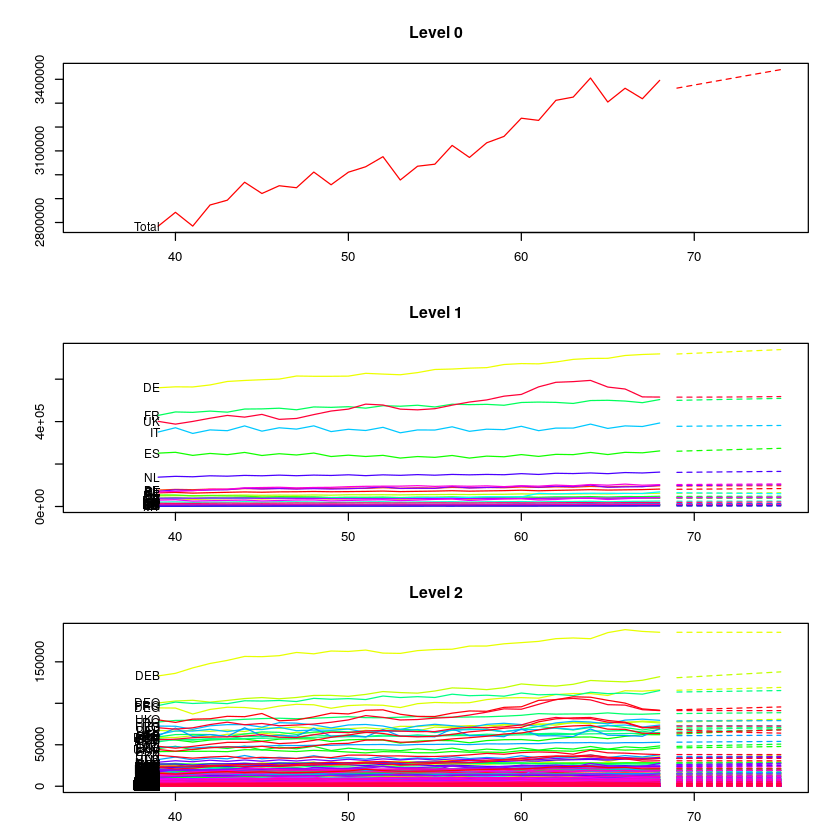

In [27]:
gdpforecast <- forecast(gts_train, h=7, method="bu")

plot(gdpforecast, include=30)

In [28]:
accuracy.gts(gdpforecast, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,71089.705530,1026.0669908,1389.1067914,492.519228,107.296255,1896.304962,19874.693381,225.8231464,210.469717,755.3348299,⋯,101.7280450,1345.546922,1346.251113,2042.8837552,447.284892,-1192.1202029,4841.082753,2.75265734,-1738.9821330,1340.659655
RMSE,83166.419737,1463.0631020,1989.9345503,873.409315,153.142671,2515.190124,21681.792132,685.5533183,258.907326,1620.0321294,⋯,177.2683439,2361.446547,1396.514734,2625.7532999,1051.461227,1633.9287079,5070.330112,685.56284521,2443.3561439,1375.101527
MAE,72545.765375,1233.0824580,1595.5684896,763.876089,129.136670,2378.695334,19874.693381,528.8410673,221.731659,1390.4420474,⋯,152.3671213,2116.313108,1346.251113,2106.9292129,949.095801,1251.7797368,4841.082753,460.10362209,2118.9849599,1340.659655
MAPE,2.068591,1.4531645,1.5996642,6.528354,2.934827,5.302043,2.632525,0.8332964,4.113043,3.4590929,⋯,4.3754249,2.858287,4.187436,2.2311211,2.771341,3.4735705,6.835335,0.70536516,2.3128872,6.003355
MPE,2.025229,1.1957964,1.3851127,3.882324,2.400202,4.074180,2.632525,0.3499023,3.879903,1.7746732,⋯,2.7929423,1.753346,4.187436,2.1607170,1.236362,-3.3181695,6.835335,-0.01096043,-1.9065761,6.003355
MASE,1.390205,0.9294849,0.8509902,1.685777,1.539356,1.845530,2.796328,0.5428274,2.149417,0.9785633,⋯,0.7733698,1.076280,1.186262,0.9222495,1.069449,0.8102811,2.614954,0.28220020,0.8449964,1.884219


In [29]:
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]

Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


In [30]:
allts <- aggts(gts_train)

In [31]:
dim(allts)

[1]  68 309

In [32]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

### RW with drift

In [33]:
# Select preferred time-series forecasting method for each time series

for(i in 1:ncol(allts))
  allf[,i] <- rwf(allts[,i], h=7, drift=TRUE)$mean
allf <- ts(allf)

In [34]:
colnames(allf)  <-   colnames(allts)  

In [35]:
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)

In [36]:
forecasts_7 = y.f[[1]]

In [37]:
colnames(forecasts_7) = colnames(y[[1]])

In [38]:
data_f5 = rbind(gts_train[[1]], forecasts_7)

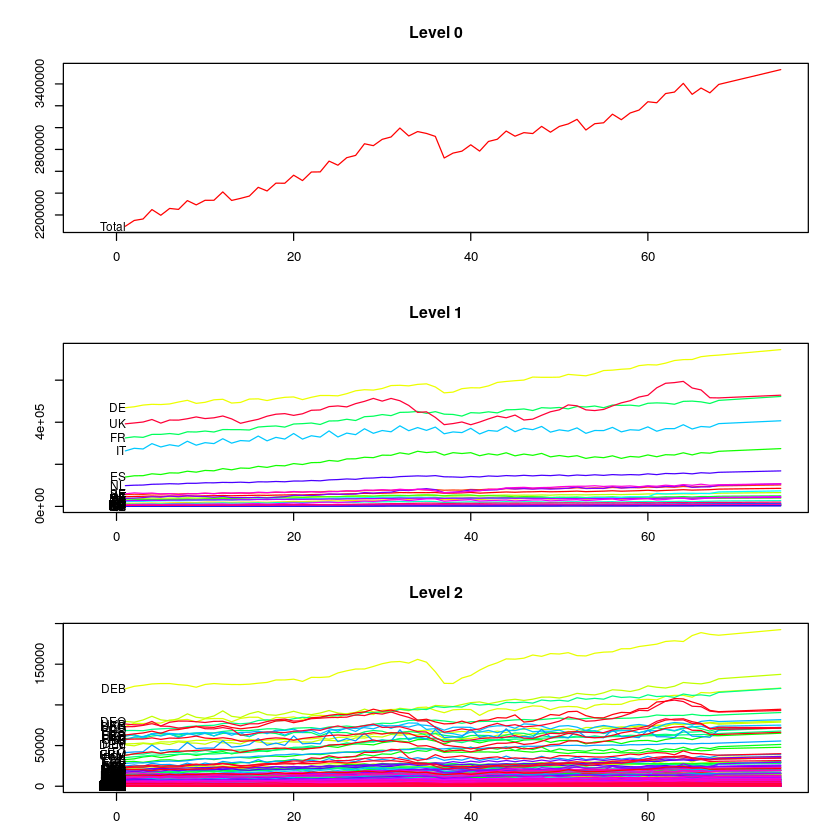

In [39]:
y_f5 = hts(data_f5, characters = c(2,1))

plot(y_f5, levels = c(0, 1, 2))

In [40]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [41]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,1.856923e+01,-475.7310235,-1406.520256,-225.141151,55.729069,2009.057640,14824.939232,-846.917058,167.958849,622.418230,⋯,106.225906,1586.176333,878.097868,965.945096,-141.3789979,-2211.251706,-75.0997868,932.871962,-1174.674947,899.591471
RMSE,3.477671e+04,1150.7610563,1923.609541,714.426753,118.980977,2698.234093,16911.064059,1134.665549,230.242122,1459.836103,⋯,178.657164,2536.151831,954.433723,1654.173448,769.7848380,2603.476776,1069.9818138,1301.103055,1937.011434,1009.214680
MAE,2.828225e+04,917.5448827,1635.004264,602.071429,106.028856,2542.940938,14824.939232,880.569723,195.960768,1275.250213,⋯,153.651279,2305.394670,878.097868,1315.571748,612.7681237,2211.251706,899.8264392,1190.905011,1634.135928,899.591471
MAPE,8.161775e-01,1.1129593,1.670034,5.471035,2.429486,5.665155,1.959375,1.387490,3.641841,3.179747,⋯,4.408838,3.109398,2.729106,1.395556,1.8252981,6.089185,1.2768190,1.787168,1.785817,4.015585
MPE,-1.570216e-02,-0.5971693,-1.443361,-2.414915,1.209920,4.306223,1.959375,-1.334772,3.062157,1.450681,⋯,2.926405,2.078354,2.729106,1.012123,-0.4768099,-6.089185,-0.1247281,1.383024,-1.294138,4.015585


In [42]:
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]

RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,58849.27,1.7150060,-0.4830031,NA
Test set,34776.71,0.8161775,-0.3038002,0.4691468


### Snaive

In [43]:
allts <- aggts(gts_train)

In [44]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [45]:
# Select preferred time-series forecasting method for each time series
for(i in 1:ncol(allts))
  allf[,i] <- snaive(msts(allts[,i], seasonal.periods = 4), h=7)$mean
allf <- ts(allf)

In [46]:
# forecast(auto.arima(train), h=7)$mean

In [47]:
colnames(allf)  <-  colnames(allts)  

In [48]:
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)

In [49]:
forecasts_7 = y.f[[1]]

In [50]:
colnames(forecasts_7) = colnames(y[[1]])

In [51]:
data_f5 = rbind(gts_train[[1]], forecasts_7)

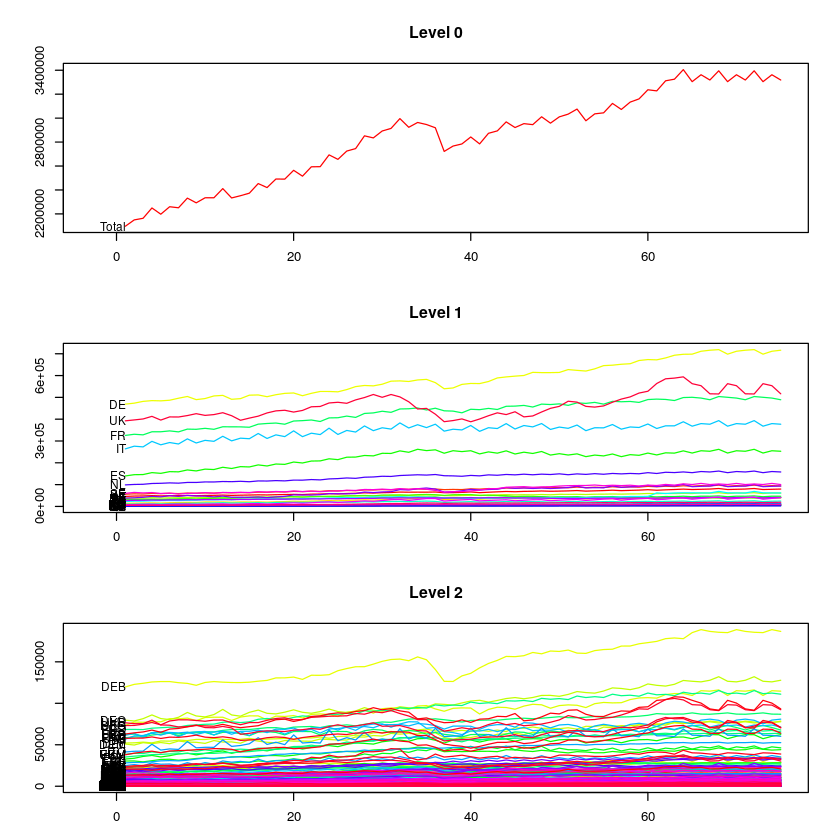

In [52]:
y_f5 = hts(data_f5, characters = c(2,1))

plot(y_f5, levels = c(0, 1, 2))

In [53]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [54]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,1.348581e+05,4786.692857,4160.857143,1132.771429,289.038095,4904.13810,38611.214286,2722.871429,615.30000,1176.507143,⋯,-105.507143,-559.8428571,-184.600000,-2199.83571,279.250000,-2460.392857,-4274.857143,-539.6500000,-5806.335714,447.185714
RMSE,1.460437e+05,5149.190685,4330.389186,1205.142709,307.962707,5289.89445,40710.956471,2858.127652,650.73177,1266.821347,⋯,156.511080,2458.0346653,1437.343724,4004.77068,1386.288153,2587.742410,5287.373251,2930.7978194,6999.429452,829.691173
MAE,1.348581e+05,4786.692857,4160.857143,1132.771429,289.038095,4904.13810,38611.214286,2722.871429,615.30000,1176.507143,⋯,130.464286,2166.2000000,1350.185714,3538.73571,1100.850000,2460.392857,4369.000000,2490.5500000,5826.507143,694.757143
MAPE,3.858363e+00,5.675103,4.213287,9.842083,6.642002,10.84929,5.129322,4.285367,11.57169,2.940176,⋯,3.773449,2.9322957,4.205115,3.79349,3.210907,6.705564,6.134338,3.7689949,6.289565,3.131973
MPE,3.858363e+00,5.675103,4.213287,9.842083,6.642002,10.84929,5.129322,4.285367,11.57169,2.940176,⋯,-3.027268,-0.7639766,-0.559309,-2.38510,0.745333,-6.705564,-6.000639,-0.8714839,-6.267566,2.013880


In [55]:
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]

SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,108505.4,3.463232,0.8651959,NA
Test set,146043.7,3.858363,0.5407384,2.451424


### Theta

In [56]:
allts <- aggts(gts_train)

In [57]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [58]:
# Select preferred time-series forecasting method for each time series
for(i in 1:ncol(allts))
  allf[,i] <- thetaf(msts(allts[,i], seasonal.periods = 4), h=7)$mean
allf <- ts(allf)

In [59]:
# forecast(auto.arima(train), h=7)$mean

In [60]:
colnames(allf)  <-   colnames(allts)  

In [61]:
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)

In [62]:
forecasts_7 = y.f[[1]]

In [63]:
colnames(forecasts_7) = colnames(y[[1]])

In [64]:
data_f5 = rbind(gts_train[[1]], forecasts_7)

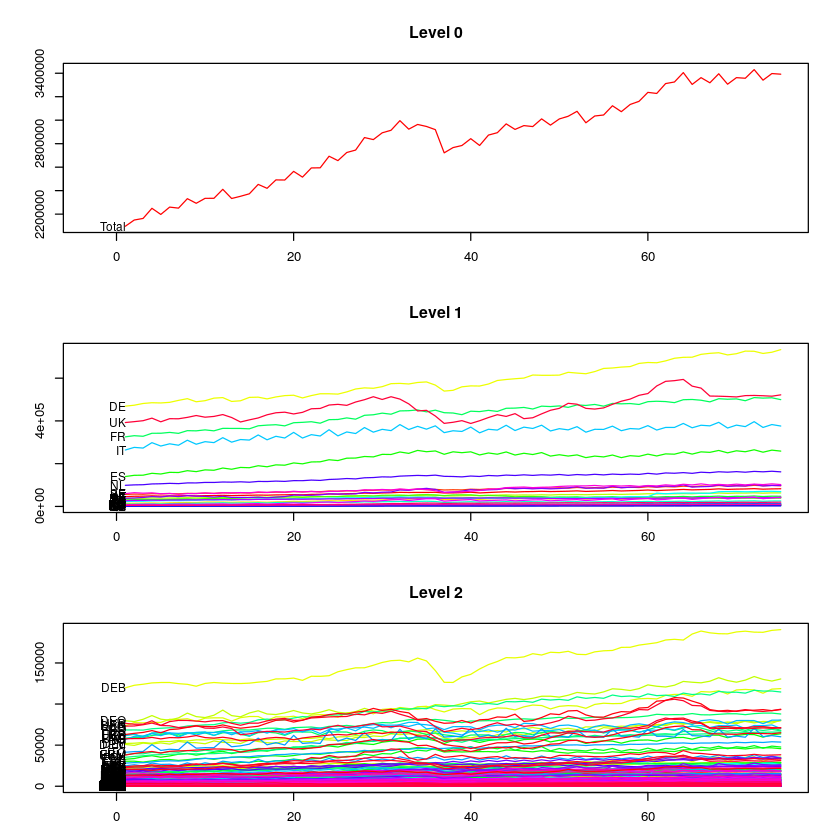

In [65]:
y_f5 = hts(data_f5, characters = c(2,1))

plot(y_f5, levels = c(0, 1, 2))

In [66]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [67]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,1.033910e+05,2309.655796,1693.869693,529.868676,152.509930,4020.180788,27792.9043,1013.691923,340.172081,1445.459712,⋯,99.769463,2002.402546,1298.205540,1260.159425,969.277926,-831.353050,123.6352534,2041.375059,-246.9957818,985.395705
RMSE,1.095004e+05,2665.716786,1820.304473,626.678545,186.557346,4333.830274,29354.6183,1094.523052,386.648161,1615.880433,⋯,163.464245,2562.582969,1428.977713,2071.141711,1275.123686,1643.377016,1071.0171586,2456.338166,1460.1489114,1088.868006
MAE,1.033910e+05,2309.655796,1693.869693,529.868676,153.469625,4020.180788,27792.9043,1013.691923,340.172081,1445.459712,⋯,135.246169,2403.240974,1298.205540,1916.590809,1107.955896,1372.309881,920.4622445,2187.422022,1183.0216402,985.395705
MAPE,2.961185e+00,2.723147,1.708997,4.482799,3.473495,8.895136,3.6906,1.593457,6.323954,3.591283,⋯,3.869882,3.233857,4.032113,2.048695,3.213689,3.777535,1.3042622,3.275828,1.2944671,4.406095
MPE,2.961185e+00,2.723147,1.708997,4.482799,3.449913,8.895136,3.6906,1.593457,6.323954,3.591283,⋯,2.756107,2.659231,4.032113,1.327092,2.787908,-2.359727,0.1558078,3.047082,-0.2872396,4.406095


In [68]:
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]

Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


### ARIMA

In [33]:
allts <- aggts(gts_train)

In [34]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [35]:
auto_arima_orders  <-   matrix(, nrow=ncol(allts), ncol=6)

In [42]:
# library(doParallel)
library(doMC)
options(cores = 8)
registerDoMC()

In [37]:
# Select preferred time-series forecasting method for each time series

start_time <- Sys.time()

for(i in 1:ncol(allts)){
    model  <- auto.arima(msts(allts[,i], seasonal.periods = 4))
    order  <-  model$arma
    auto_arima_orders[i,1]  <- order[1]
    auto_arima_orders[i,2]  <- order[6]
    auto_arima_orders[i,3]  <- order[2]
    auto_arima_orders[i,4]  <- order[3]
    auto_arima_orders[i,5]  <- order[7]
    auto_arima_orders[i,6]  <- order[4]
    allf[,i] <- forecast(model, h=7)$mean
}

end_time <- Sys.time()
end_time - start_time

Time difference of 3.691789 mins

In [ ]:
start_time <- Sys.time()

foreach(i=1:ncol(allts)) %dopar% {
    model  <- auto.arima(msts(allts[,i], seasonal.periods = 4))
    order  <-  model$arma
    auto_arima_orders[i,1]  <- order[1]
    auto_arima_orders[i,2]  <- order[6]
    auto_arima_orders[i,3]  <- order[2]
    auto_arima_orders[i,4]  <- order[3]
    auto_arima_orders[i,5]  <- order[7]
    auto_arima_orders[i,6]  <- order[4]
    allf[,i] <- forecast(model, h=7)$mean
    }

end_time <- Sys.time()

In [44]:
end_time - start_time

Time difference of 1.332911 mins

In [45]:
allf <- ts(allf)

In [46]:
head(auto_arima_orders)

2,0,0,2,1,0
1,0,1,0,1,2
1,0,2,0,1,1
1,0,0,0,1,1
1,1,1,0,1,1
1,0,1,0,1,1


In [47]:
df_auto_arima_orders  <-  as.data.frame(auto_arima_orders)

In [48]:
colnames(df_auto_arima_orders)  <- c('p', 'd', 'q', 'P', 'D', 'Q')
rownames(df_auto_arima_orders)  <- colnames(allts)

In [49]:
head(df_auto_arima_orders)

,p,d,q,P,D,Q
Total,2,0,0,2,1,0
AT,1,0,1,0,1,2
BE,1,0,2,0,1,1
BG,1,0,0,0,1,1
CY,1,1,1,0,1,1
CZ,1,0,1,0,1,1


In [50]:
colnames(allf)  <-   colnames(allts)  

In [51]:
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)

In [52]:
forecasts_7 = y.f[[1]]

In [53]:
colnames(forecasts_7) = colnames(y[[1]])

In [54]:
data_f5 = rbind(gts_train[[1]], forecasts_7)

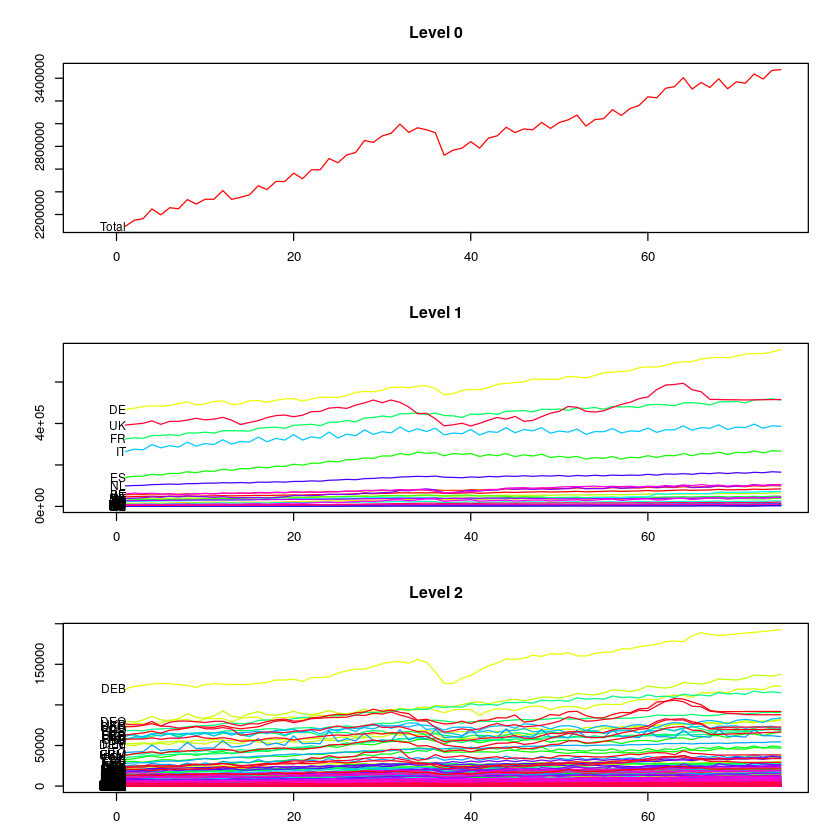

In [55]:
y_f5 = hts(data_f5, characters = c(2,1))

plot(y_f5, levels = c(0, 1, 2))

In [56]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [57]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,71723.396170,1898.065872,1247.011175,893.308155,551.59591,3382.931836,12616.73556,767.813210,658.64184,2475.631775,⋯,-295.816754,1089.304037,2715.290819,4908.20991,191.1397517,-1427.303105,959.696919,676.8474276,282.0826089,1087.432609
RMSE,72776.575270,1993.466937,1376.669046,1023.384036,784.26749,3591.869717,13090.70183,1317.830784,835.45455,2521.045992,⋯,326.470505,2214.474033,2746.966331,5264.48529,919.5114162,1836.955701,1324.934802,1104.2324145,1320.3521774,1144.893032
MAE,71723.396170,1898.065872,1247.011175,893.308155,639.20546,3382.931836,12616.73556,1105.696799,658.64184,2475.631775,⋯,295.816754,1969.606508,2715.290819,4908.20991,843.5116473,1448.636701,1191.453139,1010.4451147,1062.8401767,1087.432609
MAPE,2.061832,2.251789,1.267861,7.823035,14.92972,7.509354,1.67705,1.738627,12.81914,6.214569,⋯,8.807457,2.666521,8.465146,5.23242,2.4804008,4.013095,1.675955,1.5198920,1.1584538,4.863171
MPE,2.061832,2.251789,1.267861,7.823035,12.99178,7.509354,1.67705,1.210899,12.81914,6.214569,⋯,-8.807457,1.406386,8.465146,5.23242,0.4874357,-3.957525,1.339900,0.9973949,0.2865828,4.863171


In [58]:
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]

ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


#### Модель 3: ARIMAX 

- лучшие предикторы - близкие ряды?



##### Выбор самых близких друг к другу рядов

In [60]:
library(dtw)

In [61]:
df_eu = read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",")

In [62]:
rownames(df_eu) = as.Date(df_eu$X0)
df_eu$X0 <- NULL

In [63]:
df_eu  <- df_eu[ , order(names(df_eu))]

In [64]:
diss_mat_dtw  <- matrix(, nrow = dim(df_eu)[2], ncol = dim(df_eu)[2])

In [65]:
start_time <- Sys.time()

for (i in 1:dim(df_eu)[2]){
    for (j in 1:dim(df_eu)[2]){
        diss_mat_dtw[i,j] = dtw(df_eu[colnames(df_eu)[i]],df_eu[colnames(df_eu)[j]])$distance 
    }
}

end_time <- Sys.time()

end_time - start_time

Time difference of -5.695545 mins

In [ ]:
start_time <- Sys.time()

foreach(i=1:dim(df_eu)[2]) %dopar% {
    for (j in 1:dim(df_eu)[2]){
        diss_mat_dtw[i,j] = dtw(df_eu[colnames(df_eu)[i]],df_eu[colnames(df_eu)[j]])$distance 
    }
}

end_time <- Sys.time()

In [67]:
end_time - start_time

Time difference of 1.375565 mins

In [68]:
diag(diss_mat_dtw) <- NA

In [69]:
closests_dtw <- c()

for (i in 1:dim(df_eu)[2]){
    closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
}

In [70]:
names_dtw <- c()

for (i in closests_dtw){
    names_dtw  <-  c(names_dtw, colnames(df_eu)[i])
}

In [71]:
iii  <- 150

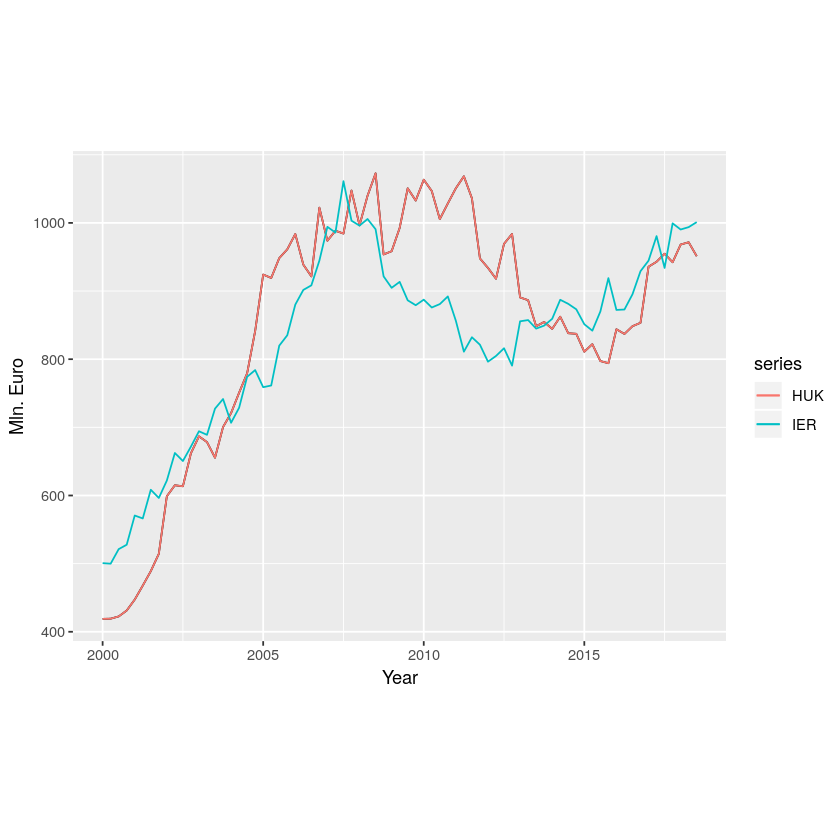

In [72]:
autoplot(ts(df_eu[names_dtw[iii]], frequency = 4, start = 2000)) +
    autolayer(ts(df_eu[names_dtw[iii]], frequency = 4, start = 2000), series=names_dtw[iii]) +
    autolayer(ts(df_eu[iii], frequency = 4, start = 2000), series=colnames(df_eu)[iii]) +
    xlab("Year") + ylab("Mln. Euro") +
    theme(aspect.ratio = 0.75)


  

In [73]:
length(names_dtw)

[1] 280

In [74]:
names_dtw_1  <-  c(rep(NA, 30), names_dtw)

In [75]:
library(TSA)


Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar



In [76]:
allts <- aggts(gts_train)

In [77]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [78]:
head(df_auto_arima_orders)

,p,d,q,P,D,Q
Total,2,0,0,2,1,0
AT,1,0,1,0,1,2
BE,1,0,2,0,1,1
BG,1,0,0,0,1,1
CY,1,1,1,0,1,1
CZ,1,0,1,0,1,1


In [79]:
df_auto_arima_orders[31,]

,p,d,q,P,D,Q
ATB,0,1,0,2,0,0


In [ ]:
for(i in 1:30){
    model  <- auto.arima(msts(allts[,i], seasonal.periods = 4))
    allf[,i] <- forecast(model, h=7)$mean
}

In [85]:
allts[,names_dtw_1[i]]

Time Series:
Start = 1 
End = 68 
Frequency = 1 
 [1] 1669.90 1633.75 1626.40 1659.80 1663.60 1698.45 1698.60 1790.30 1705.10
[10] 1741.90 1810.85 1919.30 1753.40 1901.15 1932.55 2098.05 1910.15 1929.60
[19] 1925.00 2062.10 1802.50 1947.80 1963.75 2113.75 1967.35 2060.50 2082.60
[28] 2176.20 2042.30 2126.05 2102.70 2318.90 2143.90 2314.05 2378.00 2547.60
[37] 2371.10 2352.05 2374.35 2648.75 2402.70 2434.10 2516.55 2599.10 2515.15
[46] 2438.45 2364.60 2549.50 2375.90 2478.85 2404.45 2573.40 2548.65 2557.85
[55] 2610.60 2781.50 2582.10 2474.50 2540.40 2793.15 2696.10 2715.25 2607.20
[64] 2944.95 2805.65 2834.70 2773.75 2990.80

In [83]:
i = 35

arimax(msts(allts[,i], seasonal.periods = 4), order = c(df_auto_arima_orders[i,1], df_auto_arima_orders[i,2], df_auto_arima_orders[i,3]), seasonal = list(order = c(df_auto_arima_orders[i,4], df_auto_arima_orders[i,5], df_auto_arima_orders[i,6]), period = 4),
 xreg = allts[,names_dtw_1[i]],  method="ML")
    


Call:
arimax(x = msts(allts[, i], seasonal.periods = 4), order = c(df_auto_arima_orders[i, 
    1], df_auto_arima_orders[i, 2], df_auto_arima_orders[i, 3]), seasonal = list(order = c(df_auto_arima_orders[i, 
    4], df_auto_arima_orders[i, 5], df_auto_arima_orders[i, 6]), period = 4), 
    xreg = allts[, names_dtw_1[i]], method = "ML")

Coefficients:
          ma1    xreg
      -0.2068  0.3401
s.e.   0.1410  0.1131

sigma^2 estimated as 12436:  log likelihood = -410.94,  aic = 825.88

In [592]:
# Select preferred time-series forecasting method for each time series

for(i in 1:30){
    model  <- auto.arima(msts(allts[,i], seasonal.periods = 4))
    allf[,i] <- forecast(model, h=7)$mean
}

for(i in 31:ncol(allts)){
    model  <- arimax(msts(allts[,i], seasonal.periods = 4), order = c(df_auto_arima_orders[i,1], df_auto_arima_orders[i,2], df_auto_arima_orders[i,3]), seasonal = list(order = c(df_auto_arima_orders[i,4], df_auto_arima_orders[i,5], df_auto_arima_orders[i,6]), period = 4),
 xreg = allts[,names_dtw_1[i]],  method="ML")
    
    a  <-  gts_test[[1]][,names_dtw_1[i]]
    
    allf[,i] <- predict(model, n.ahead=7, newxreg = a)$pred
    
}

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”Warning message in log(s2):
“NaNs produced”Warning message in log(s2):
“NaNs produced”Warning message in log(s2):
“NaNs produced”Warning message in log(s2):
“NaNs produced”

In [603]:
allf <- ts(allf)

In [594]:
colnames(allf)  <-   colnames(allts)  

In [620]:
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g,
keep = "gts", algorithms = "lu")

In [621]:
forecasts_7 = y.f[[1]]

In [622]:
colnames(forecasts_7) = colnames(y[[1]])

In [623]:
data_f5 = rbind(gts_train[[1]], forecasts_7)

Warning message in hts(data_f5, characters = c(2, 3)):
“The argument characters is not fully specified for the bottom names.”

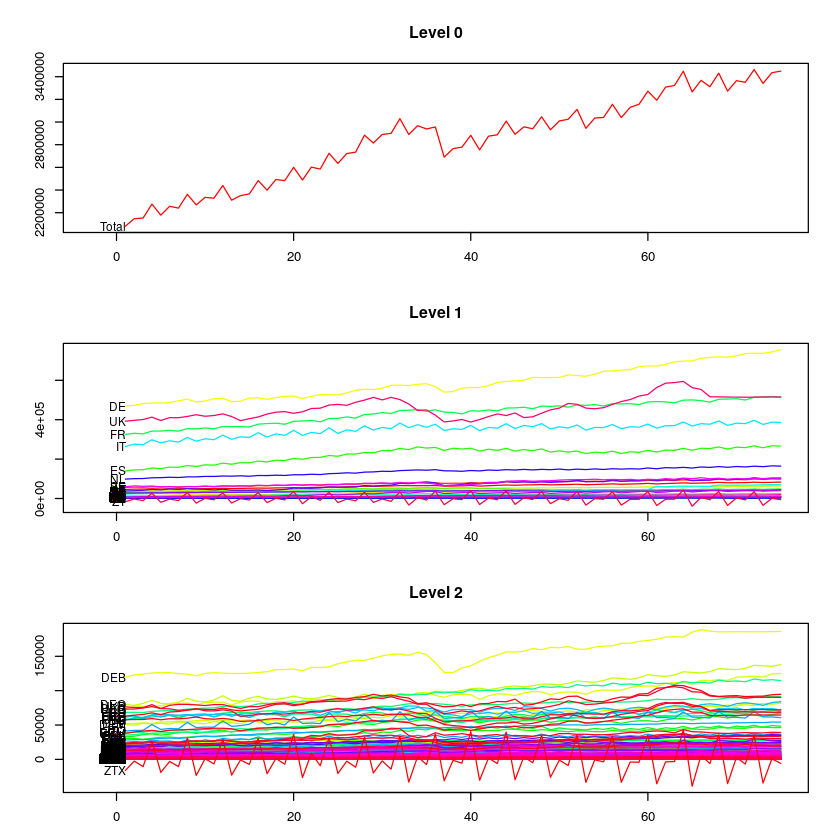

In [624]:
y_f5 = hts(data_f5, characters = c(2,3))

plot(y_f5, levels = c(0, 1, 2))

In [625]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [626]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR,ZTX
ME,81627.482399,2358.268370,1755.822458,1419.20432,981.44029,3868.069630,12945.838644,1234.900200,1154.10719,2997.112772,⋯,1540.526218,1650.436337,2973.027059,325.9481827,-1710.727075,1778.541206,1716.221468,-603.7111268,1726.584288,-2548.05053
RMSE,83516.597308,2516.936466,1796.286479,1457.71036,1025.26838,4121.572570,13531.230115,1402.307195,1186.68059,3080.104577,⋯,2474.586894,1678.064717,3338.842925,1141.6184619,2219.665983,2062.700788,2214.660895,1484.5287809,1836.846994,3498.66033
MAE,81627.482399,2358.268370,1755.822458,1419.20432,981.44029,3868.069630,12945.838644,1234.900200,1154.10719,2997.112772,⋯,2295.750419,1650.436337,2973.027059,1060.6671184,1747.860080,1919.681561,1937.086338,1233.3227532,1726.584288,3234.26398
MAPE,2.347558,2.791981,1.778041,12.35681,22.73743,8.568496,1.719792,1.942422,21.93772,7.518711,⋯,3.100935,5.149762,3.163156,3.1104657,4.836816,2.700748,2.897309,1.3424037,7.739449,59.43921
MPE,2.347558,2.791981,1.778041,12.35681,22.73743,8.568496,1.719792,1.942422,21.93772,7.518711,⋯,2.018274,5.149762,3.163156,0.8685776,-4.738905,2.496089,2.551380,-0.6678593,7.739449,55.58554


#### Модель 4: bvarr/BMR

- [bvarr](https://github.com/bdemeshev/bvarr), [bvarrKK](https://github.com/bdemeshev/bvarrKK), [bvar_om](https://github.com/bdemeshev/bvar_om)

- [BMR: documantation](https://www.kthohr.com/bmr.html), [pdf](https://www.kthohr.com/bmr/BMR.pdf)

- https://github.com/joergrieger/bvar

- [bvarsv](https://cran.r-project.org/web/packages/bvarsv/bvarsv.pdf)

- [MSBVAR: Markov-switching Bayesian VAR](https://cran.r-project.org/package=MSBVAR)


#### Модель 5: VAR


R: there is a package called "vars" which deals with VAR models.

Python: PyFlux has support for VARs and Bayesian VARs.


К недостаткам VAR-моделей можно отнести неопределённость в выборе подходящей длины лага, значительное число оцениваемых параметров и то, что все переменные в модели должны быть стационарными.

- All variables have to be of the same order of integration. 

- All the variables are I(0) (stationary): this is in the standard case, i.e. a VAR in level
- All the variables are I(d) (non-stationary) with d > 0:
    - The variables are cointegrated: the error correction term has to be included in the VAR. The model becomes a __Vector error correction model (VECM)__ which can be seen as a restricted VAR.
    - The variables are not cointegrated: the variables have first to be differenced d times and one has a VAR in difference.

To use VAR model for non-stationary series, you have to test the cointegration If there is cointegration you use the model VECM Otherwise a VAR on the first differences of the variables


Because of the parameter identification problem, ordinary least squares estimation of the structural VAR would yield inconsistent parameter estimates. This problem can be overcome by rewriting the VAR in reduced form.

- ADL
- Parameter identification problem
- Structural vs. reduced form
- Granger causality, impulse responses, and forecast error variance decompositions


